In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Ignore harmless warnings
warnings.filterwarnings("ignore")


# --- Prints cortos de Bloque 0 (al final del bloque) ---
root = "/kaggle/input/nfl-big-data-bowl-2026-prediction"
train_dir = os.path.join(root, "train")

print(f"[B0] Dataset raíz: {root}")
print(f"[B0] Existe carpeta train: {os.path.exists(train_dir)}")
print(f"[B0] Archivos en raíz: {sorted(os.listdir(root))}")

# Cuenta inputs/outputs por semana para verificar integridad
inputs = sorted([f for f in os.listdir(train_dir) if f.startswith("input_2023_w")])
outputs = sorted([f for f in os.listdir(train_dir) if f.startswith("output_2023_w")])

print(f"[B0] Inputs pre-release (semanas): {len(inputs)}  | Outputs post-release (semanas): {len(outputs)}")
print("[B0] Listo: entorno cargado y archivos detectados.")

/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


In [21]:
import cuml.accel

In [22]:

cuml.accel.install()

[2025-10-15 02:50:57.546] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-10-15 02:50:57.546] [CUML] [info] cuML: Installed accelerator for umap.
[2025-10-15 02:50:57.546] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-10-15 02:50:57.546] [CUML] [info] cuML: Successfully initialized accelerator.


### Bloque 1 · Imports, configuración y utilidades básicas

In [23]:
# Imports estándar
import os
import gc
import math
import numpy as np
import pandas as pd

# Modelado y ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos base (puedes añadir más luego)
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optimización bayesiana con Optuna (si no está, puedes `pip install optuna` en Kaggle)
import optuna

# Semillas para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Constantes geométricas del campo
FIELD_X_MAX = 120.0
FIELD_Y_MAX = 53.3

# Función para convertir grados a radianes de forma segura
def deg2rad(angle_deg):
    return np.deg2rad(angle_deg % 360.0)

# Pequeño epsilon para evitar divisiones por cero
EPS = 1e-6


### Bloque 2 · Carga de datos (train input/output y test input)

In [24]:
# Define aquí tus rutas reales
DATA_DIR = "/kaggle/input/nfl-big-data-bowl-2026-prediction/train"
TEST_DIR = "/kaggle/input/nfl-big-data-bowl-2026-prediction"

# Ejemplo de carga por lotes de semanas; ajusta si ya los tienes concatenados
def load_train_inputs_outputs(data_dir):
    # Lista de archivos input y output
    inputs, outputs = [], []
    for w in range(1, 19):
        inp_path = os.path.join(data_dir, f"input_2023_w{w:02d}.csv")
        out_path = os.path.join(data_dir, f"output_2023_w{w:02d}.csv")
        if os.path.exists(inp_path):
            inputs.append(pd.read_csv(inp_path))
        if os.path.exists(out_path):
            outputs.append(pd.read_csv(out_path))
    inp = pd.concat(inputs, ignore_index=True)
    out = pd.concat(outputs, ignore_index=True)
    return inp, out

def load_test_input(test_dir):
    test_input_path = os.path.join(test_dir, "test_input.csv")
    return pd.read_csv(test_input_path)

# Carga (esto puede tardar según entorno)
inp_raw, out_raw = load_train_inputs_outputs(DATA_DIR)
test_inp_raw = load_test_input(TEST_DIR)

#4,880,579 (inp_raw) = todos los frames pre-release (10 Hz) de todos los 
#jugadores en todas las jugadas, incluidos los que no puntúan.

#562,936 (out_raw) = todos los frames post-release que sí hay que predecir 
#(solo jugadores player_to_predict y solo durante el vuelo de la bola).

print(f"[B2] {'pre-release (train)':<22} | filas: {inp_raw.shape[0]:>9,} | cols: {inp_raw.shape[1]:>2} | antes del release")
print(f"[B2] {'post-release (target)':<22} | filas: {out_raw.shape[0]:>9,} | cols: {out_raw.shape[1]:>2} | a predecir")
print(f"[B2] {'test pre-release':<22} | filas: {test_inp_raw.shape[0]:>9,} | cols: {test_inp_raw.shape[1]:>2} | test")



[B2] pre-release (train)    | filas: 4,880,579 | cols: 23 | antes del release
[B2] post-release (target)  | filas:   562,936 | cols:  6 | a predecir
[B2] test pre-release       | filas:    49,753 | cols: 23 | test


### Bloque 2.5 · Reducir inp_raw a claves evaluadas

In [25]:
# Bloque 2.5 · Reducir inp_raw a claves evaluadas 

# Extrae las claves únicas (juego, jugada, jugador) que sí se evalúan (porque vienen de out_raw, que es el ground truth post-release).
# Hace un join interno entre todos los frames pre-release (inp_raw) y esa lista de claves (keys_eval).

keys_eval = out_raw[["game_id","play_id","nfl_id"]].drop_duplicates()
inp_raw = inp_raw.merge(keys_eval, on=["game_id","play_id","nfl_id"], how="inner")

print(f"[B2.5] inp_raw recortado: {inp_raw.shape[0]:,} filas, {inp_raw.shape[1]} cols - solo jugadores evaluados")


[B2.5] inp_raw recortado: 1,303,440 filas, 23 cols - solo jugadores evaluados


### Bloque 3 · Selección del “frame 0” (último pre-release por jugador/jugada)

In [26]:
# Extrae el último frame pre-release (t=0) por {game_id, play_id, nfl_id}
def get_frame0(df_input):
    # Ordena por frame_id para asegurar que el último queda al final
    df = df_input.sort_values(["game_id", "play_id", "nfl_id", "frame_id"])
    # Toma el último frame por grupo
    f0 = df.groupby(["game_id", "play_id", "nfl_id"], as_index=False).tail(1).copy()
    # Renombra x,y,s,a,o,dir a versión con sufijo 0 para claridad
    f0 = f0.rename(columns={
        "x":"x0","y":"y0","s":"s0","a":"a0","o":"o0","dir":"dir0"
    })
    return f0

f0 = get_frame0(inp_raw)
f0.shape


n_plays_b3 = f0[["game_id","play_id"]].drop_duplicates().shape[0]
n_players_b3 = f0["nfl_id"].nunique()

print(f"[B3] {'f0 (frame 0)':<22} | filas: {f0.shape[0]:>9,} | cols: {f0.shape[1]:>2} | 1 fila por jugador/jugada")
print(f"[B3] {'jugadas únicas':<22} | total: {n_plays_b3:>10,}")
print(f"[B3] {'jugadores únicos':<22} | total: {n_players_b3:>10,}")

[B3] f0 (frame 0)           | filas:    46,045 | cols: 23 | 1 fila por jugador/jugada
[B3] jugadas únicas         | total:     14,108
[B3] jugadores únicos       | total:      1,178


### Bloque 4 · Normalización de dirección (todo a “ofensa hacia la derecha”)

In [27]:
# Aplica simetría horizontal cuando play_direction == "left"
# Debe ser consistente entre input (f0) y output (targets)
def normalize_direction_xy(df, x_col, y_col, playdir_col="play_direction"):
    df = df.copy()
    mask_left = df[playdir_col].str.lower() == "left"
    # Reflejo en X e Y
    df.loc[mask_left, x_col] = FIELD_X_MAX - df.loc[mask_left, x_col]
    df.loc[mask_left, y_col] = FIELD_Y_MAX - df.loc[mask_left, y_col]
    return df

def normalize_direction_angles(df, angle_cols, playdir_col="play_direction"):
    df = df.copy()
    mask_left = df[playdir_col].str.lower() == "left"
    # Para simetría horizontal: nuevo ángulo = (180 - ángulo) mod 360
    for c in angle_cols:
        df.loc[mask_left, c] = (180.0 - df.loc[mask_left, c]) % 360.0
    return df

def normalize_play_direction_inputs(f0):
    df = f0.copy()
    df = normalize_direction_xy(df, "x0", "y0")
    df = normalize_direction_xy(df, "ball_land_x", "ball_land_y")
    df = normalize_direction_angles(df, ["o0","dir0"])
    return df

def normalize_play_direction_outputs(out_df, inp_ref):
    # Une play_direction desde input para tener la misma referencia
    ref = inp_ref[["game_id","play_id","nfl_id","play_direction"]]
    out = out_df.merge(ref, on=["game_id","play_id","nfl_id"], how="left")
    out = normalize_direction_xy(out, "x", "y")
    return out.drop(columns=["play_direction"])

# Normaliza
f0_norm = normalize_play_direction_inputs(f0)
out_norm = normalize_play_direction_outputs(out_raw, f0)
f0_norm.shape, out_norm.shape


print(f"[B4] {'f0_norm':<22} | filas: {f0_norm.shape[0]:>9,} | cols: {f0_norm.shape[1]:>2} | input normalizado")
print(f"[B4] {'out_norm':<22} | filas: {out_norm.shape[0]:>9,} | cols: {out_norm.shape[1]:>2} | target normalizado")
print("[B4] Nota: todo queda en eje común (ofensa→derecha).")



[B4] f0_norm                | filas:    46,045 | cols: 23 | input normalizado
[B4] out_norm               | filas:   562,936 | cols:  6 | target normalizado
[B4] Nota: todo queda en eje común (ofensa→derecha).


### Bloque 4.5 · Inserta esto justo después del Bloque 4.

In [28]:
# Filtro por los jugadores que realmente puntúan en la competencia
# Trabajamos solo con player_to_predict == True para reducir datos y alinear el objetivo

# 1) Filtra el frame 0
f0_norm = f0_norm[f0_norm["player_to_predict"] == True].copy()

# 2) Sincroniza los outputs con el filtro anterior (solo esos jugadores/jugadas)
out_norm = out_norm.merge(
    f0_norm[["game_id","play_id","nfl_id"]],
    on=["game_id","play_id","nfl_id"],
    how="inner"
)



# 3) Prints mínimos alineados
print(f"[B4.5] {'f0_norm filtrado':<22} | filas: {f0_norm.shape[0]:>9,} | cols: {f0_norm.shape[1]:>2} | ptp=True")
print(f"[B4.5] {'out_norm sync':<22} | filas: {out_norm.shape[0]:>9,} | cols: {out_norm.shape[1]:>2} | frames evaluados")
print("[B4.5] Nota: solo jugadores que puntúan; targets mantienen todos sus frames.")

[B4.5] f0_norm filtrado       | filas:    46,045 | cols: 23 | ptp=True
[B4.5] out_norm sync          | filas:   562,936 | cols:  6 | frames evaluados
[B4.5] Nota: solo jugadores que puntúan; targets mantienen todos sus frames.


### Bloque 5A · Definir make_features (ingeniería de features base)

Bloque 5A · Definir make_features (ingeniería de features base)
Este bloque solo define la función make_features, que toma el dataset largo por frame (train_long) y construye las variables de entrada para el modelo. Calcula rasgos geométricos y cinemáticos (distancia y ángulo hacia el punto de aterrizaje del balón, diferencias angulares con orientación/dirección, componentes de velocidad, interacciones con el tiempo relativo) y rasgos físicos del jugador (altura en pulgadas, peso). Devuelve el DataFrame listo para modelar (train_df) y las listas de columnas: NUM_COLS (numéricas), CAT_COLS (categóricas) y Y_COLS (targets dx_t, dy_t). No ejecuta transformaciones por sí mismo; solo prepara la función que se usa en el Bloque 5.

In [29]:
# === Bloque 5A: definición de make_features (debe ir antes de llamarla en Bloque 5) ===
def make_features(train_long):
    df = train_long.copy()

    def height_to_inches(h):
        try:
            if isinstance(h, str) and "-" in h:
                ft, inch = h.split("-")
                return int(ft)*12 + int(inch)
        except Exception:
            pass
        return np.nan

    def wrap_angle(a):
        return (a + np.pi) % (2*np.pi) - np.pi

    df["dx_ball0"] = df["ball_land_x"] - df["x0"]
    df["dy_ball0"] = df["ball_land_y"] - df["y0"]
    df["dist_ball0"] = np.hypot(df["dx_ball0"], df["dy_ball0"])

    df["o0_rad"]   = deg2rad(df["o0"])
    df["dir0_rad"] = deg2rad(df["dir0"])
    df["ang_to_ball0"] = np.arctan2(df["dy_ball0"], df["dx_ball0"])
    df["d_ang_o_ball"]   = wrap_angle(df["ang_to_ball0"] - df["o0_rad"])
    df["d_ang_dir_ball"] = wrap_angle(df["ang_to_ball0"] - df["dir0_rad"])

    df["vx0"] = df["s0"] * np.cos(df["dir0_rad"])
    df["vy0"] = df["s0"] * np.sin(df["dir0_rad"])

    df["s0_t"] = df["s0"] * df["t_norm"]
    df["a0_t"] = df["a0"] * df["t_norm"]
    df["dist_ball0_t"] = df["dist_ball0"] * df["t_norm"]

    df["height_in"] = df["player_height"].apply(height_to_inches)
    df["weight_lb"] = pd.to_numeric(df["player_weight"], errors="coerce")

    num_cols = [
        "x0","y0","s0","a0","absolute_yardline_number",
        "ball_land_x","ball_land_y","dx_ball0","dy_ball0","dist_ball0",
        "o0_rad","dir0_rad","d_ang_o_ball","d_ang_dir_ball",
        "vx0","vy0","T","t","t_norm","s0_t","a0_t","dist_ball0_t",
        "height_in","weight_lb"
    ]
    cat_cols = ["player_side","player_role","player_position"]
    y_cols   = ["dx_t","dy_t"]

    missing = [c for c in (num_cols + cat_cols + y_cols) if c not in df.columns]
    if missing:
        raise KeyError(f"Faltan columnas en make_features: {missing}")

    df_model = df.dropna(subset=y_cols).copy()
    return df_model, num_cols, cat_cols, y_cols
# === fin Bloque 5A ===


### Bloque 5 · Construcción del dataset supervisado en forma “larga” (targets en Δ)

Bloque 5 · Construcción del dataset supervisado “largo”
En este bloque se crea train_long uniendo el estado del frame 0 normalizado (f0_norm) con el ground truth post-release (out_norm), generando una fila por cada frame del vuelo de la pelota (t=1..T) para cada {game_id, play_id, nfl_id}. Sobre ese dataset se calculan los targets en deltas (dx_t = x − x0, dy_t = y − y0) y los índices de tiempo (T, t, t_norm). Luego, con make_features(train_long) se produce train_df, que añade las features geométricas y cinemáticas necesarias y devuelve también las listas NUM_COLS, CAT_COLS y Y_COLS. En resumen, train_long es el dataset por frame a predecir y train_df es la versión lista para modelar.

train_long une el estado del frame 0 (pre-release) con el ground truth (post-release) y crea una fila por cada frame en que la pelota está en el aire (t=1..T) para cada {game_id, play_id, nfl_id}. Aquí se calculan los targets como desplazamientos relativos: dx_t = x − x0 y dy_t = y − y0, además de T, t y t_norm. Es la tabla “base” por frame, útil para análisis/EDA y para verificar la construcción de objetivos.

train_df aplica la función make_features(train_long) para añadir variables de entrada (distancias/ángulos hacia el punto de aterrizaje, componentes de velocidad, interacciones con el tiempo, altura/peso, etc.). Este es el dataset listo para modelar: de aquí saldrán las matrices X e y tras el split por jugada (en el Bloque 7). En resumen, train_long contiene los objetivos por frame, y train_df es train_long + features, el que efectivamente se usa para entrenamiento y validación.

In [30]:
# Une f0 con out para crear filas por frame_id=t con features del frame 0
def build_supervised_long(f0_norm, out_norm):
    # Selecciona columnas útiles del frame 0
    keep_f0 = [
        "game_id","play_id","nfl_id","player_to_predict","player_side","player_role","player_position",
        "x0","y0","s0","a0","o0","dir0","absolute_yardline_number",
        "ball_land_x","ball_land_y","num_frames_output","play_direction","player_height","player_weight","player_birth_date"
    ]
    base = f0_norm[keep_f0].copy()

    # Une con los outputs normalizados
    df = out_norm.merge(base, on=["game_id","play_id","nfl_id"], how="left")

    # Calcula desplazamientos Δ respecto al frame 0
    df["dx_t"] = df["x"] - df["x0"]
    df["dy_t"] = df["y"] - df["y0"]

    # Índices de tiempo relativos
    df["T"] = df["num_frames_output"].clip(lower=1)
    df["t"] = df["frame_id"].astype(int)
    df["t_norm"] = df["t"] / df["T"]

    # Limpieza de tipos básicos
    df["player_to_predict"] = df["player_to_predict"].astype(bool)

    return df

#train_long = build_supervised_long(f0_norm, out_norm)
#train_long.shape

train_long = build_supervised_long(f0_norm, out_norm)
train_df, NUM_COLS, CAT_COLS, Y_COLS = make_features(train_long)

# Prints mínimos del bloque (solo función del bloque)
print(f"[B5] train_long (frames post-release): {train_long.shape}")
print(f"[B5] train_df (con features):         {train_df.shape}")

[B5] train_long (frames post-release): (562936, 29)
[B5] train_df (con features):         (562936, 44)


### Bloque 6 · Ingeniería de features (geométricas, cinemáticas y de rol)

Bloque 6 · Ingeniería de features (qué produce y qué significa)
Este bloque toma train_long (una fila por {game_id, play_id, nfl_id, frame_id}) y construye train_df, el DataFrame final para el modelo, junto con las listas NUM_COLS (numéricas), CAT_COLS (categóricas) y Y_COLS (objetivos). En NUM_COLS quedan: x0,y0 (posición inicial), s0,a0 (velocidad/aceleración), absolute_yardline_number (contexto de campo), ball_land_x,ball_land_y (punto de caída del pase), dx_ball0,dy_ball0,dist_ball0 (vector y distancia desde la posición inicial al punto de caída), o0_rad,dir0_rad (orientación/dirección en radianes), d_ang_o_ball,d_ang_dir_ball (diferencias angulares hacia el balón), vx0,vy0 (componentes de velocidad), T,t,t_norm (horizonte total, frame actual y su versión normalizada), s0_t,a0_t,dist_ball0_t (interacciones con el tiempo) y height_in,weight_lb (rasgos físicos). En CAT_COLS se incluyen player_side, player_role y player_position (codificadas con One-Hot). Finalmente, Y_COLS = [dx_t, dy_t] son los targets: desplazamientos del jugador respecto a x0,y0 en cada frame t. En síntesis, train_df = train_long + features y estas listas definen entrada (NUM/CAT) y salida (Y) para el entrenamiento.

* train_df: contiene las columnas originales necesarias y nuevas features que describen la geometría y la cinemática del jugador respecto al punto donde caerá el balón.

NUM_COLS (numéricas, entradas del modelo):

x0, y0: posición inicial del jugador en el frame 0.

s0, a0: velocidad y aceleración iniciales.

absolute_yardline_number: yardas hasta la endzone (contexto de campo).

ball_land_x, ball_land_y: coordenadas donde aterriza el pase.

dx_ball0, dy_ball0: diferencias desde la posición inicial hacia el punto de aterrizaje.

dist_ball0: distancia euclídea a ese punto.

o0_rad, dir0_rad: orientación y dirección de movimiento iniciales en radianes.

d_ang_o_ball, d_ang_dir_ball: diferencia angular (envuelta a [-π, π]) entre la línea hacia el balón y la orientación/dirección del jugador.

vx0, vy0: componentes de velocidad inicial (s0 * cos/sin(dir0_rad)).

T, t, t_norm: horizonte total de vuelo (frames a predecir), índice de frame posterior al release y su versión normalizada t/T.

s0_t, a0_t, dist_ball0_t: interacciones con el tiempo relativo (ayudan a modelar trayectorias no lineales).

height_in, weight_lb: rasgos físicos del jugador (altura en pulgadas y peso en libras).

* CAT_COLS (categóricas, se codifican con One-Hot): player_side (Offense/Defense), player_role (Targeted Receiver, Defensive Coverage, etc.), player_position.

* Y_COLS (objetivos): dx_t, dy_t, los desplazamientos del jugador respecto a su posición inicial (x0,y0) en cada frame t (lo que el modelo aprende a predecir).

In [31]:
# Crea columnas derivadas y prepara listas de columnas numéricas/categóricas
def make_features(train_long):
    df = train_long.copy()

    # Diferencias hacia el punto de aterrizaje del balón
    df["dx_ball0"] = df["ball_land_x"] - df["x0"]
    df["dy_ball0"] = df["ball_land_y"] - df["y0"]
    df["dist_ball0"] = np.hypot(df["dx_ball0"], df["dy_ball0"])

    # Ángulo hacia el balón (rad) y diferencias angulares con orientación y dirección
    df["ang_to_ball0"] = np.arctan2(df["dy_ball0"], df["dx_ball0"])
    df["o0_rad"]   = deg2rad(df["o0"])
    df["dir0_rad"] = deg2rad(df["dir0"])

    # Diferencias angulares envueltas a [-pi, pi]
    def wrap_angle(a):
        return (a + np.pi) % (2*np.pi) - np.pi

    df["d_ang_o_ball"]   = wrap_angle(df["ang_to_ball0"] - df["o0_rad"])
    df["d_ang_dir_ball"] = wrap_angle(df["ang_to_ball0"] - df["dir0_rad"])

    # Componentes de velocidad inicial
    df["vx0"] = df["s0"] * np.cos(df["dir0_rad"])
    df["vy0"] = df["s0"] * np.sin(df["dir0_rad"])

    # Interacciones simples con el tiempo relativo
    df["s0_t"] = df["s0"] * df["t_norm"]
    df["a0_t"] = df["a0"] * df["t_norm"]
    df["dist_ball0_t"] = df["dist_ball0"] * df["t_norm"]

    # Conversión de altura (ft-in -> pulgadas). Si viene como "6-2", convierte a 74, si NaN deja NaN
    def height_to_inches(h):
        try:
            if isinstance(h, str) and "-" in h:
                ft, inch = h.split("-")
                return int(ft)*12 + int(inch)
        except:
            pass
        return np.nan

    df["height_in"] = df["player_height"].apply(height_to_inches)
    # Peso ya suele ser numérico; si no, convierte
    df["weight_lb"] = pd.to_numeric(df["player_weight"], errors="coerce")

    # Selección de columnas de entrada
    num_cols = [
        "x0","y0","s0","a0","absolute_yardline_number",
        "ball_land_x","ball_land_y","dx_ball0","dy_ball0","dist_ball0",
        "o0_rad","dir0_rad","d_ang_o_ball","d_ang_dir_ball",
        "vx0","vy0","T","t","t_norm","s0_t","a0_t","dist_ball0_t",
        "height_in","weight_lb"
    ]
    cat_cols = ["player_side","player_role","player_position"]

    # Objetivos (desplazamientos)
    y_cols = ["dx_t","dy_t"]

    # Subconjunto final quitando filas con NaN en targets
    df_model = df.dropna(subset=y_cols).copy()

    return df_model, num_cols, cat_cols, y_cols

train_df, NUM_COLS, CAT_COLS, Y_COLS = make_features(train_long)
# Prints mínimos alineados (contexto breve)
print(f"[B6] {'train_df':<22} | filas: {train_df.shape[0]:>9,} | cols: {train_df.shape[1]:>2} | con features")
print(f"[B6] {'NUM_COLS':<22} | num: {len(NUM_COLS):>3} | incluye x0,y0,T,t,t_norm")
print(f"[B6] {'CAT_COLS':<22} | cat: {len(CAT_COLS):>3} | {', '.join(CAT_COLS)}")
print(f"[B6] {'Y_COLS':<22} | y:   {len(Y_COLS):>3} | {Y_COLS}")


[B6] train_df               | filas:   562,936 | cols: 44 | con features
[B6] NUM_COLS               | num:  24 | incluye x0,y0,T,t,t_norm
[B6] CAT_COLS               | cat:   3 | player_side, player_role, player_position
[B6] Y_COLS                 | y:     2 | ['dx_t', 'dy_t']


[B6.5] train_df: (562936, 44)  |  NUM_COLS=24  CAT_COLS=3  Y_COLS=2
[B6.5] .info() columnas del modelo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562936 entries, 0 to 562935
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   x0                        562936 non-null  float64
 1   y0                        562936 non-null  float64
 2   s0                        562936 non-null  float64
 3   a0                        562936 non-null  float64
 4   absolute_yardline_number  562936 non-null  int64  
 5   ball_land_x               562936 non-null  float64
 6   ball_land_y               562936 non-null  float64
 7   dx_ball0                  562936 non-null  float64
 8   dy_ball0                  562936 non-null  float64
 9   dist_ball0                562936 non-null  float64
 10  o0_rad                    562936 non-null  float64
 11  dir0_rad                  562936 non-null  float64
 

,count,missing,missing_pct,unique,mean,std,min,p01,p05,p50,p95,p99,max,skew
x0,562936.000000,0.000000,0.00%,11392,67.021,22.992,7.440,23.650,33.690,64.520,108.120,113.370,119.390,0.250
y0,562936.000000,0.000000,0.00%,7468,26.491,11.788,0.690,4.890,8.350,26.300,44.910,48.360,52.620,0.022
s0,562936.000000,0.000000,0.00%,988,4.812,2.052,0.000,0.610,1.430,4.770,8.200,9.110,10.340,0.030
a0,562936.000000,0.000000,0.00%,782,2.732,1.466,0.000,0.280,0.650,2.550,5.380,6.390,8.360,0.496
absolute_yardline_number,562936.000000,0.000000,0.00%,99,60.359,23.100,11.000,14.000,24.000,60.000,98.000,106.000,109.000,0.019
ball_land_x,562936.000000,0.000000,0.00%,8864,71.687,24.808,7.800,23.190,34.800,69.860,113.560,118.070,125.850,0.134
ball_land_y,562936.000000,0.000000,0.00%,7869,26.506,16.508,-4.030,-0.220,2.440,26.150,50.880,53.480,57.210,0.021
dx_ball0,562936.000000,0.000000,0.00%,39350,4.666,9.324,-21.100,-10.370,-7.310,1.990,23.490,29.930,41.590,0.853
dy_ball0,562936.000000,0.000000,0.00%,41694,0.014,9.244,-33.300,-21.880,-14.850,-0.000,15.190,21.820,49.680,0.015
dist_ball0,562936.000000,0.000000,0.00%,46045,11.779,7.444,0.022,0.960,2.599,9.762,26.707,32.702,49.740,0.946


[B6.5] Top-10 categorías por variable categórica:


,count,pct
player_side,,
Defense,402576,71.51%
Offense,160360,28.49%


,count,pct
player_role,,
Defensive Coverage,402576,71.51%
Targeted Receiver,160360,28.49%


,count,pct
player_position,,
CB,172674,30.67%
WR,108067,19.20%
FS,71862,12.77%
SS,56876,10.10%
ILB,40009,7.11%
TE,32195,5.72%
OLB,28316,5.03%
MLB,27721,4.92%
RB,18681,3.32%


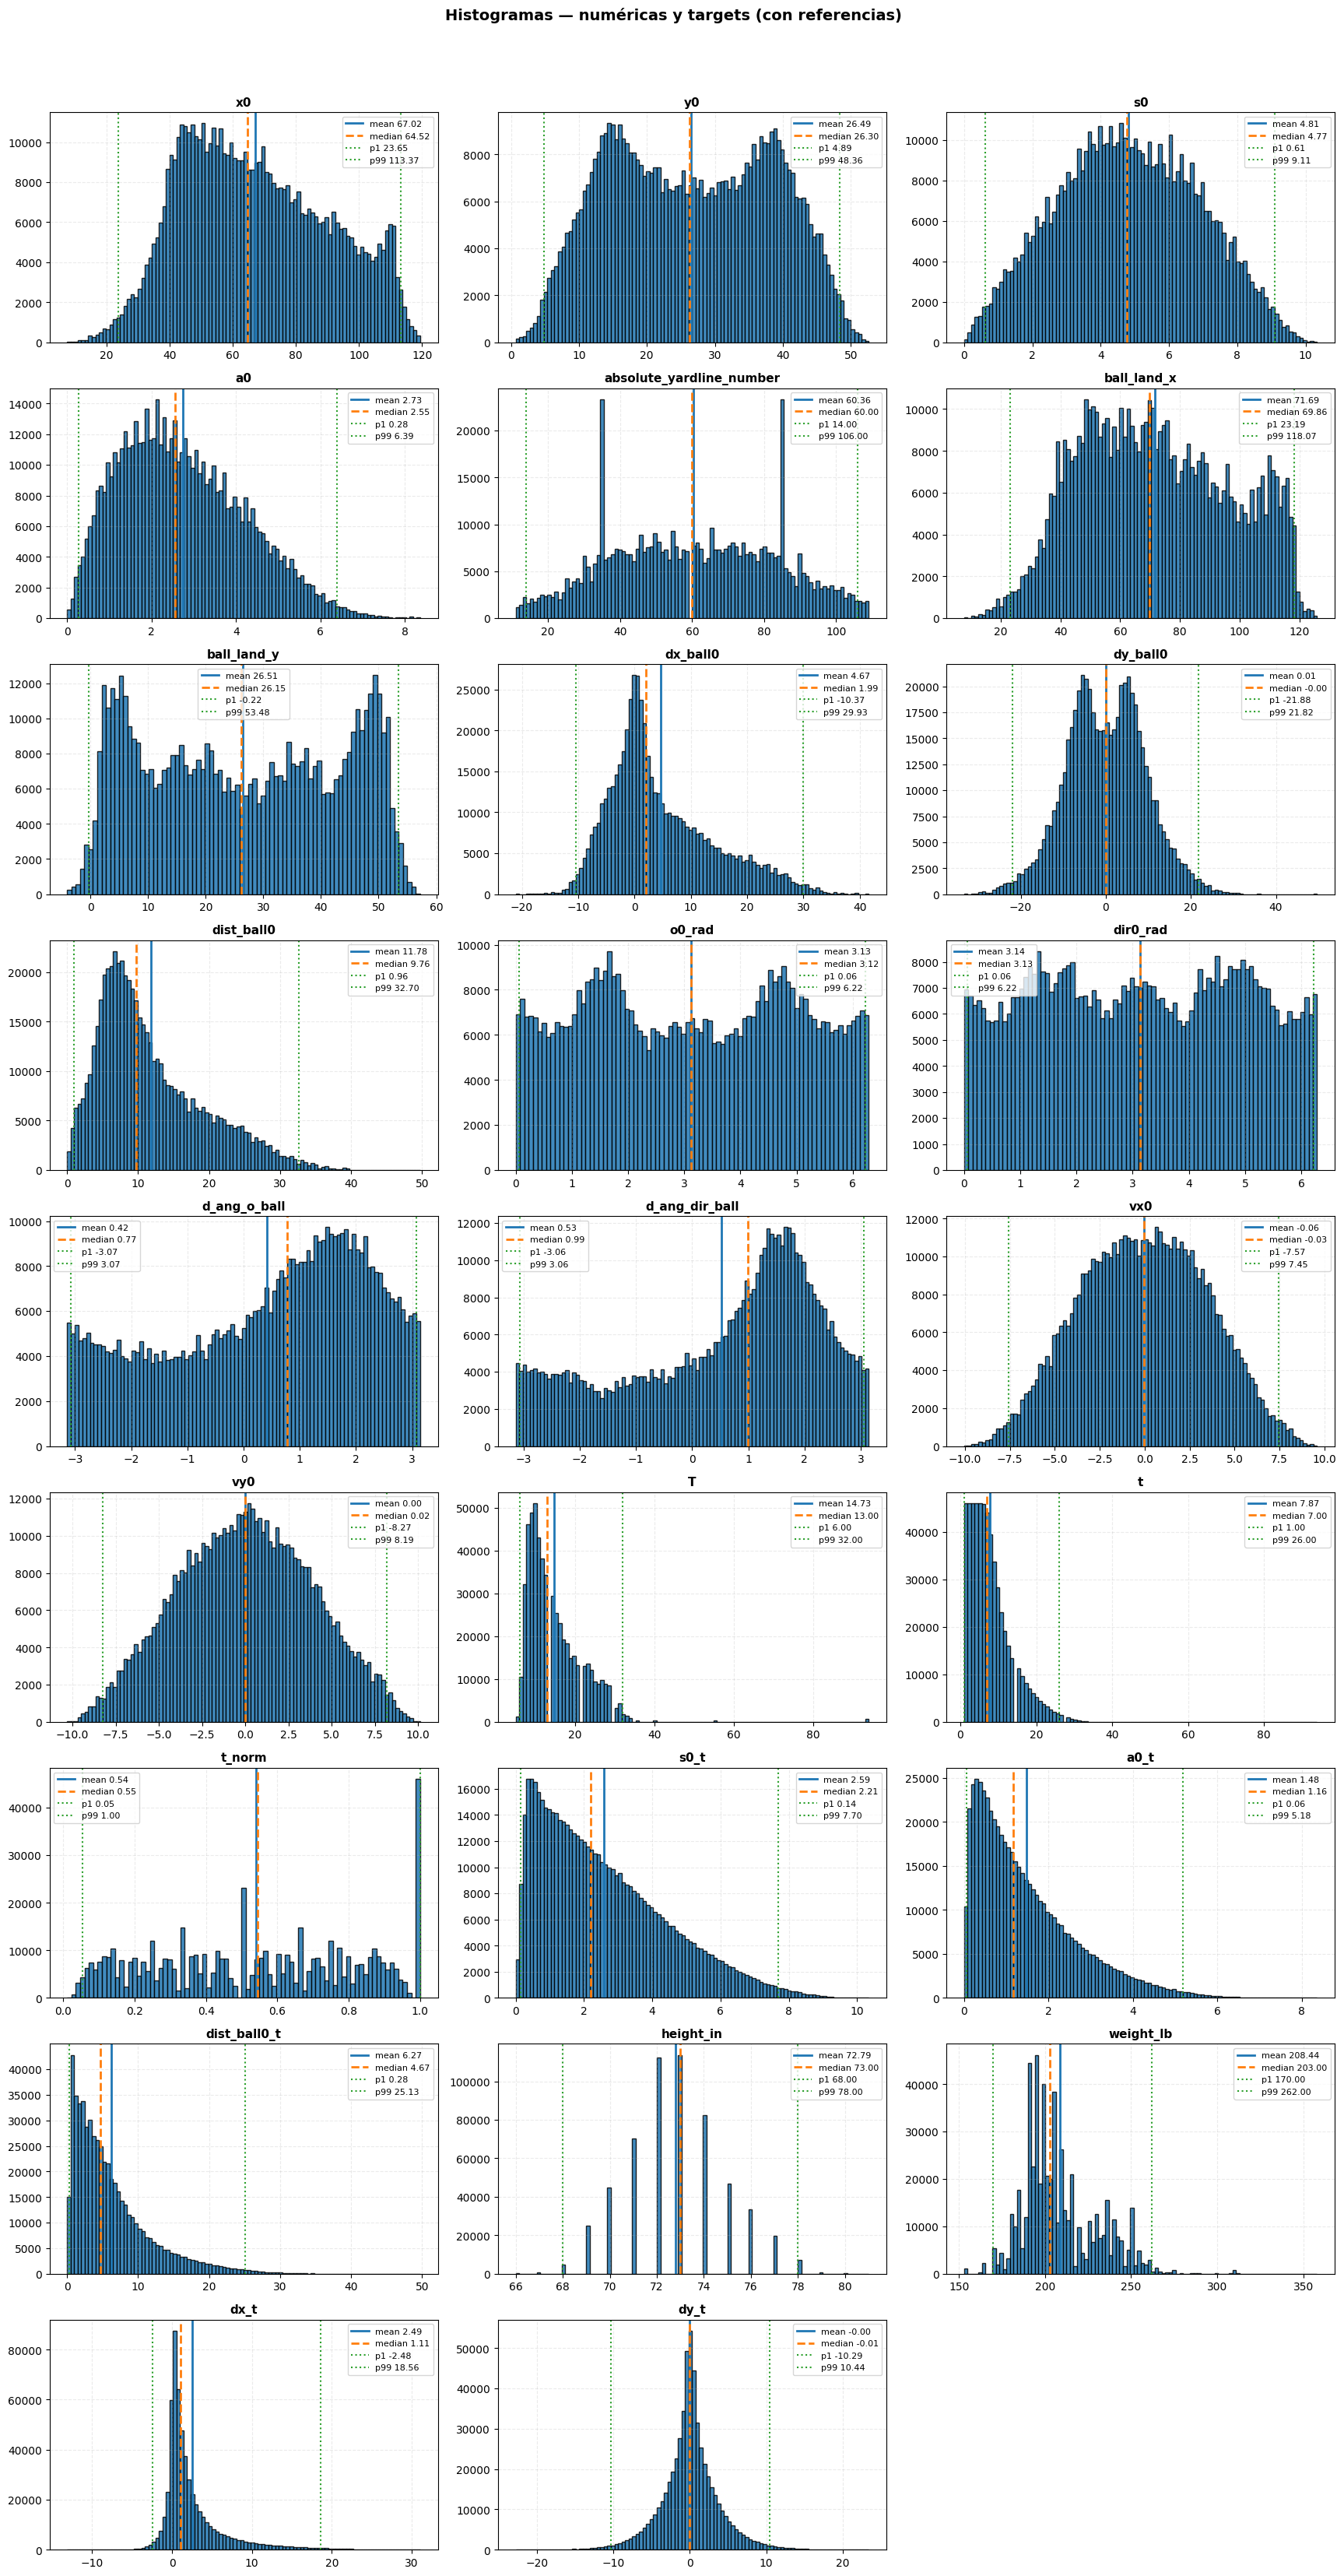

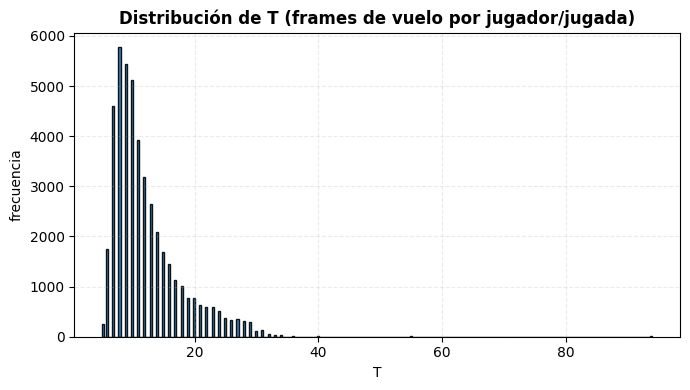

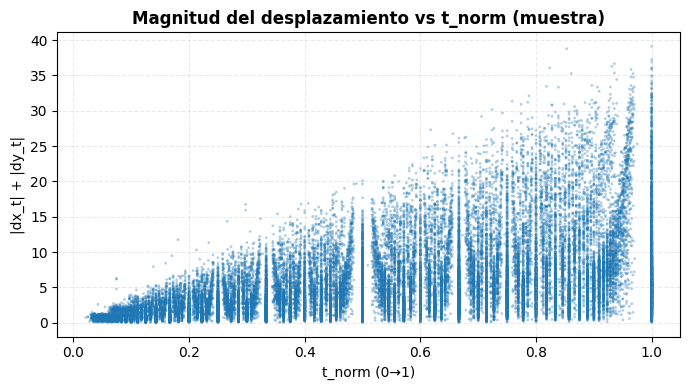

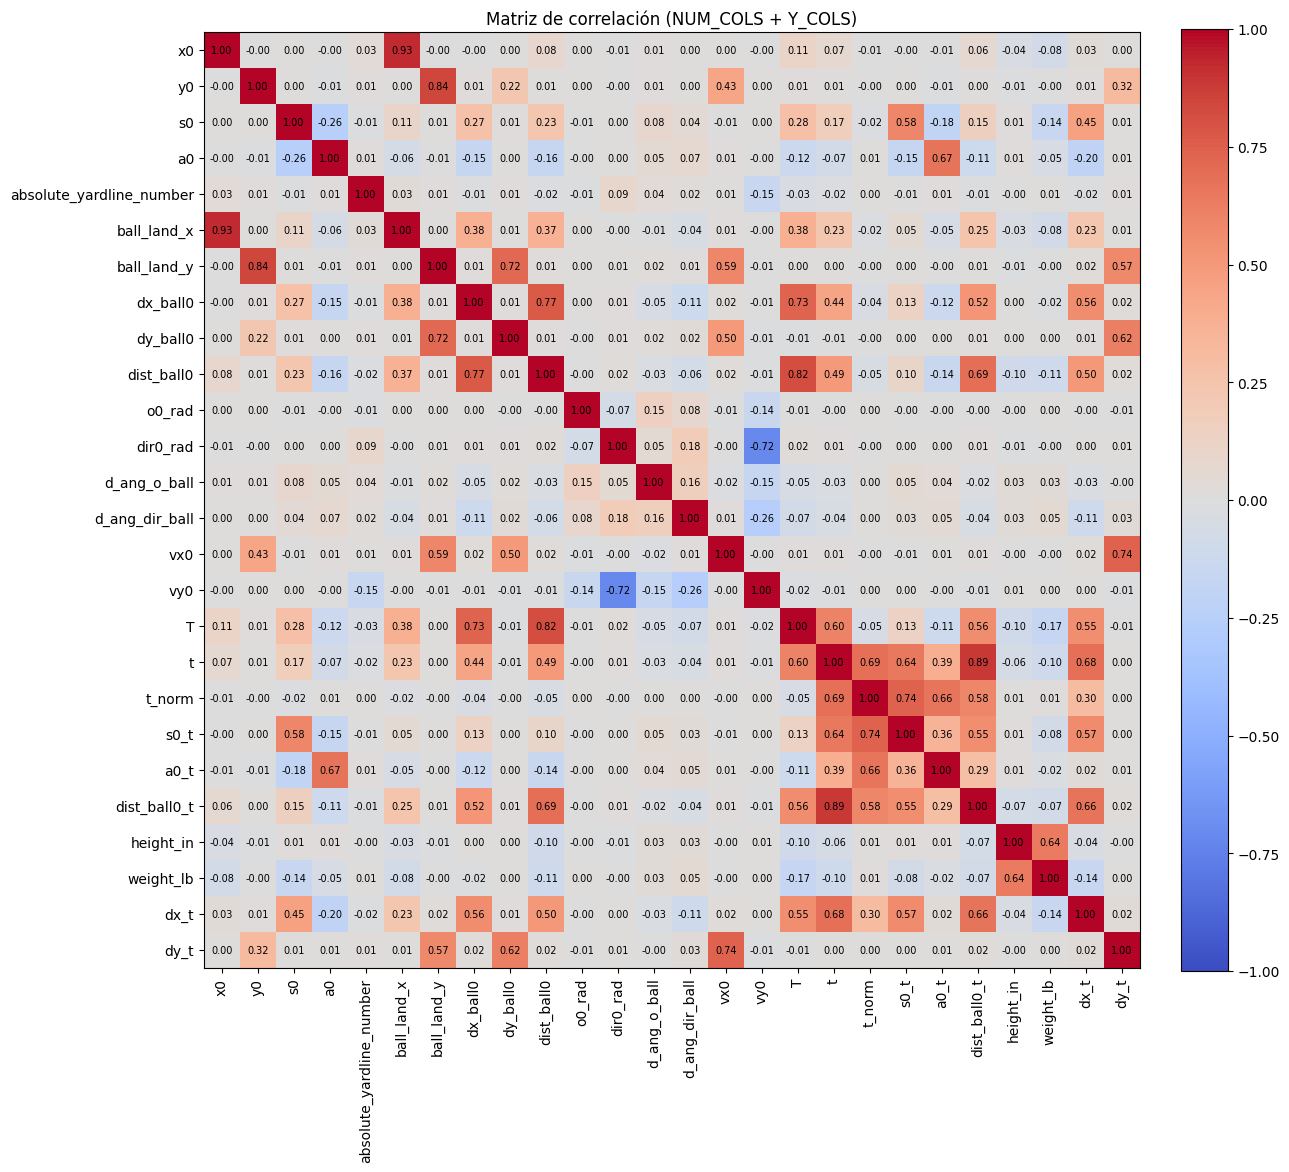

[B6.5] EDA completado: NaN, histogramas, categóricas, T, scatter t_norm y correlación.


In [32]:
# === Bloque 6.5 · EDA visual PRO (después del Bloque 6, antes del Bloque 7) ===
# Requiere: train_df, train_long, NUM_COLS, CAT_COLS, Y_COLS, RANDOM_STATE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

print(f"[B6.5] train_df: {train_df.shape}  |  NUM_COLS={len(NUM_COLS)}  CAT_COLS={len(CAT_COLS)}  Y_COLS={len(Y_COLS)}")

# --------------------------------------------------------------------------------
# 1) info() formateado (solo para inspección por consola)
# --------------------------------------------------------------------------------
buf = StringIO()
train_df[NUM_COLS + CAT_COLS + Y_COLS].info(buf=buf)
print("[B6.5] .info() columnas del modelo:")
print(buf.getvalue())

# --------------------------------------------------------------------------------
# 2) Tabla 'describe' enriquecida (numéricas + targets) con estilo
#    - Incluye faltantes (%), únicos, skew, percentiles finos
# --------------------------------------------------------------------------------
def numeric_summary(df, cols):
    d = df[cols].apply(pd.to_numeric, errors='coerce')
    desc = d.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T
    desc['missing'] = d.shape[0] - desc['count']
    desc['missing_pct'] = 100 * desc['missing'] / d.shape[0]
    desc['unique'] = d.nunique(dropna=True)
    desc['skew'] = d.skew(numeric_only=True)
    ordered = ['count','missing','missing_pct','unique','mean','std','min','1%','5%','50%','95%','99%','max','skew']
    return desc.rename(columns={'1%':'p01','5%':'p05','50%':'p50','95%':'p95','99%':'p99'})[
        ['count','missing','missing_pct','unique','mean','std','min','p01','p05','p50','p95','p99','max','skew']
    ]

num_desc = numeric_summary(train_df, NUM_COLS + Y_COLS).round(3)

# Estilo profesional para notebooks (pandas Styler)
styled_desc = (
    num_desc.style
    .format({
        'missing_pct': "{:.2f}%",
        'mean': "{:.3f}", 'std': "{:.3f}",
        'min': "{:.3f}", 'p01': "{:.3f}", 'p05': "{:.3f}", 'p50': "{:.3f}",
        'p95': "{:.3f}", 'p99': "{:.3f}", 'max': "{:.3f}", 'skew': "{:.3f}"
    })
    .bar(subset=['missing_pct'], color='#f5b7b1')  # barra visual para % faltantes
    .background_gradient(subset=['mean','std','skew'], cmap='Blues')
    .set_caption("Resumen enriquecido (numéricas + targets)")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size','14px'), ('font-weight','bold'), ('text-align','left'), ('color','#333')]},
        {'selector': 'th.col_heading', 'props': [('background-color','#f7f7f9'), ('color','#333'), ('font-weight','bold')]},
        {'selector': 'th.row_heading', 'props': [('color','#333')]}
    ])
)
display(styled_desc)

# --------------------------------------------------------------------------------
# 3) Top-10 de categóricas (estilado)
# --------------------------------------------------------------------------------
cat_tables = {}
for c in CAT_COLS:
    vc = (train_df[c].fillna("NA")
          .value_counts(dropna=False)
          .head(10)
          .rename("count")
          .to_frame())
    vc['pct'] = (vc['count'] / len(train_df) * 100).round(2)
    cat_tables[c] = vc

print("[B6.5] Top-10 categorías por variable categórica:")
for c, tbl in cat_tables.items():
    display(
        tbl.style
        .format({'pct': '{:.2f}%'})
        .bar(subset=['count'], color='#aed6f1')
        .set_caption(f"Top-10 categorías — {c}")
    )

# --------------------------------------------------------------------------------
# 4) Histogramas pro en grilla (numéricas + targets)
#    - Bins: regla de Freedman–Diaconis (robusta a outliers)
#    - Líneas: media (—), mediana (--), p1/p99 (:)
#    - Etiquetas y estética consistente
# --------------------------------------------------------------------------------
def fd_bins(x):
    """Freedman–Diaconis bin count (robusto)."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 10
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    if iqr == 0:
        return min(50, max(10, int(np.sqrt(x.size))))
    bw = 2 * iqr * x.size ** (-1/3)
    if bw <= 0:
        return min(50, max(10, int(np.sqrt(x.size))))
    return int(np.clip((x.max() - x.min()) / bw, 10, 100))

grid_cols = 3  # cambia a 2 si prefieres dos columnas
plot_cols = NUM_COLS + Y_COLS
n = len(plot_cols)
rows = int(np.ceil(n / grid_cols))

fig, axes = plt.subplots(rows, grid_cols, figsize=(grid_cols*5.8, rows*3.6))
axes = np.array(axes).reshape(rows, grid_cols)

for i, col in enumerate(plot_cols):
    r, c = divmod(i, grid_cols)
    ax = axes[r, c]
    x = pd.to_numeric(train_df[col], errors='coerce').dropna().values
    if len(x) == 0:
        ax.set_visible(False)
        continue

    bins = fd_bins(x)
    ax.hist(x, bins=bins, edgecolor='black', alpha=0.85)
    ax.grid(alpha=0.25, linestyle='--')
    ax.set_title(col, fontsize=11, fontweight='bold')

    # líneas de referencia
    mean = np.mean(x); med = np.median(x)
    p01, p99 = np.percentile(x, [1,99])
    ax.axvline(mean, color='#1f77b4', linewidth=2, label=f"mean {mean:.2f}")
    ax.axvline(med, color='#ff7f0e', linestyle='--', linewidth=2, label=f"median {med:.2f}")
    ax.axvline(p01, color='#2ca02c', linestyle=':', linewidth=1.5, label=f"p1 {p01:.2f}")
    ax.axvline(p99, color='#2ca02c', linestyle=':', linewidth=1.5, label=f"p99 {p99:.2f}")

    # anotación compacta
    ax.legend(fontsize=8, frameon=True)

# Apaga ejes sobrantes
for j in range(i+1, rows*grid_cols):
    r, c = divmod(j, grid_cols)
    axes[r, c].axis("off")

plt.suptitle("Histogramas — numéricas y targets (con referencias)", y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------
# 5) Distribución de T (frames de vuelo por jugador/jugada)
# --------------------------------------------------------------------------------
T_series = train_long.groupby(["game_id","play_id","nfl_id"])["frame_id"].max()
plt.figure(figsize=(7,4))
plt.hist(T_series.values, bins='auto', edgecolor='black', alpha=0.9)
plt.grid(alpha=0.25, linestyle='--')
plt.title("Distribución de T (frames de vuelo por jugador/jugada)", fontsize=12, fontweight='bold')
plt.xlabel("T"); plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------
# 6) Relación t_norm vs |Δ| (muestra) — con estilo mejorado
# --------------------------------------------------------------------------------
sample = train_df.sample(min(50_000, len(train_df)), random_state=RANDOM_STATE)
disp_mag = sample["dx_t"].abs() + sample["dy_t"].abs()

plt.figure(figsize=(7,4))
plt.scatter(sample["t_norm"].values, disp_mag.values, s=4, alpha=0.35, edgecolors='none')
plt.grid(alpha=0.25, linestyle='--')
plt.title("Magnitud del desplazamiento vs t_norm (muestra)", fontsize=12, fontweight='bold')
plt.xlabel("t_norm (0→1)"); plt.ylabel("|dx_t| + |dy_t|")
plt.tight_layout()
plt.show()



# --------------------------------------------------------------------------------
# 7) Matriz de correlación (NUM_COLS + Y_COLS) con anotaciones
# --------------------------------------------------------------------------------
corr_cols = NUM_COLS + Y_COLS
corr = train_df[corr_cols].corr()
plt.figure(figsize=(max(8, 0.5*len(corr_cols)), max(6, 0.5*len(corr_cols))))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)  # colormap explícito porque lo pediste
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=np.arange(len(corr_cols)), labels=corr_cols, rotation=90)
plt.yticks(ticks=np.arange(len(corr_cols)), labels=corr_cols)
# Anotar valores
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        val = corr.iloc[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)
plt.title("Matriz de correlación (NUM_COLS + Y_COLS)")
plt.tight_layout()
plt.show()

print("[B6.5] EDA completado: NaN, histogramas, categóricas, T, scatter t_norm y correlación.")
# === fin Bloque 6.5 ===



### Bloque 7 · Split 60/20/20 por jugada (sin fuga de información)

In [33]:
# Split por {game_id, play_id} para que una jugada no aparezca en varios conjuntos
def split_by_play(df, test_size_eval=0.2, test_size_valid=0.2, random_state=RANDOM_STATE):
    # Obtiene únicas jugadas
    plays = df[["game_id","play_id"]].drop_duplicates().copy()

    # Primero separación evaluation (20%)
    plays_train_valid, plays_eval = train_test_split(
        plays,
        test_size=test_size_eval,
        random_state=random_state,
        shuffle=True
    )

    # Luego dentro del train_valid, saca validación (20% de todo → 25% de este subconjunto)
    plays_train, plays_valid = train_test_split(
        plays_train_valid,
        test_size=test_size_valid / (1 - test_size_eval),
        random_state=random_state,
        shuffle=True
    )

    def subset(p):
        return df.merge(p, on=["game_id","play_id"], how="inner")

    train = subset(plays_train)
    valid = subset(plays_valid)
    eval_ = subset(plays_eval)

    return train, valid, eval_

train_set, valid_set, eval_set = split_by_play(train_df)
train_set.shape, valid_set.shape, eval_set.shape

print("train:", train_set.shape, "valid:", valid_set.shape, "eval:", eval_set.shape)


train: (337582, 44) valid: (110826, 44) eval: (114528, 44)


#### Chequeo de partición 60/20/20 por jugada y fugas

In [34]:
# === Chequeo de partición 60/20/20 por jugada y fugas ===
def _n_plays(df): 
    return df[["game_id","play_id"]].drop_duplicates().shape[0]

tot_plays = _n_plays(train_df)
tr_plays  = _n_plays(train_set)
va_plays  = _n_plays(valid_set)
ev_plays  = _n_plays(eval_set)

def _pct(a, b): 
    return 100.0 * a / b if b else 0.0

print(f"[B7] Jugadas totales         : {tot_plays:>7,}")
print(f"[B7] Train (plays)           : {tr_plays:>7,}  ({_pct(tr_plays, tot_plays):5.1f}%)  ~60%")
print(f"[B7] Valid (plays)           : {va_plays:>7,}  ({_pct(va_plays, tot_plays):5.1f}%)  ~20%")
print(f"[B7] Eval  (plays)           : {ev_plays:>7,}  ({_pct(ev_plays, tot_plays):5.1f}%)  ~20%")

# También por filas (frames), solo informativo
tot_rows = len(train_df); tr_rows = len(train_set); va_rows = len(valid_set); ev_rows = len(eval_set)
print(f"[B7] Train (filas)           : {tr_rows:>7,}  ({_pct(tr_rows, tot_rows):5.1f}%)")
print(f"[B7] Valid (filas)           : {va_rows:>7,}  ({_pct(va_rows, tot_rows):5.1f}%)")
print(f"[B7] Eval  (filas)           : {ev_rows:>7,}  ({_pct(ev_rows, tot_rows):5.1f}%)")
print(f"[B7] Suma filas = total      : {tr_rows + va_rows + ev_rows == tot_rows}")

# Comprobación de fugas: una jugada no debe aparecer en varios sets
tr_keys = set(map(tuple, train_set[["game_id","play_id"]].drop_duplicates().values))
va_keys = set(map(tuple, valid_set[["game_id","play_id"]].drop_duplicates().values))
ev_keys = set(map(tuple, eval_set[["game_id","play_id"]].drop_duplicates().values))

leak_tv = tr_keys & va_keys
leak_te = tr_keys & ev_keys
leak_ve = va_keys & ev_keys

assert len(leak_tv) == 0 and len(leak_te) == 0 and len(leak_ve) == 0, "¡Fuga detectada entre splits!"
print("[B7] Sin fugas por jugada (train/valid/eval son disjuntos).")


[B7] Jugadas totales         :  14,108
[B7] Train (plays)           :   8,464  ( 60.0%)  ~60%
[B7] Valid (plays)           :   2,822  ( 20.0%)  ~20%
[B7] Eval  (plays)           :   2,822  ( 20.0%)  ~20%
[B7] Train (filas)           : 337,582  ( 60.0%)
[B7] Valid (filas)           : 110,826  ( 19.7%)
[B7] Eval  (filas)           : 114,528  ( 20.3%)
[B7] Suma filas = total      : True
[B7] Sin fugas por jugada (train/valid/eval son disjuntos).


### Bloque 8 · Preprocesamiento, matrices y métricas 

In [35]:
# === Bloque 8 · Preprocesamiento, matrices y métricas ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import clone
import numpy as np
import pandas as pd

# ColumnTransformer: escala numéricas y OneHot a categóricas
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), NUM_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), CAT_COLS)
    ],
    remainder="drop"
)

# Matrices (usa solo features del modelo)
FEATURES_FOR_MODEL = NUM_COLS + CAT_COLS
X_train = train_set[FEATURES_FOR_MODEL].copy()
y_train = train_set[Y_COLS].values  # columnas [dx_t, dy_t]
X_valid = valid_set[FEATURES_FOR_MODEL].copy()
y_valid = valid_set[Y_COLS].values
X_eval  = eval_set[FEATURES_FOR_MODEL].copy()
y_eval  = eval_set[Y_COLS].values

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

EPS = 1e-6  # evitar divisiones por cero en MAPE

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred, multioutput='uniform_average')
    mse = mean_squared_error(y_true, y_pred, multioutput='uniform_average')
    r2  = r2_score(y_true, y_pred, multioutput='uniform_average')
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), EPS, None)))
    return {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape}

def rmse_2d(y_true, y_pred):
    # RMSE combinando dx y dy
    return np.sqrt(mean_squared_error(y_true, y_pred, multioutput='uniform_average'))

print(f"[B8] X_train={X_train.shape}  X_valid={X_valid.shape}  X_eval={X_eval.shape}")
print("[B8] Preprocesamiento y métricas listos.")



[B8] X_train=(337582, 27)  X_valid=(110826, 27)  X_eval=(114528, 27)
[B8] Preprocesamiento y métricas listos.


### Bloque 9 · Catálogo de modelos + espacios de hiperparámetros (con justificación breve)

In [36]:
# === Bloque 9 · Catálogo de modelos y espacios de hiperparámetros (Optuna) ===
import optuna
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# XGBoost (opcional si está disponible)
HAS_XGB = False
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    pass

# Gaussian Process (opcional: muy pesado)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

N_TRIALS_DEFAULT = 10        # puedes subir luego
MAX_TUNE_ROWS = 120_000      # submuestreo para acelerar tuning (ajusta si quieres)

def make_estimator(name, trial):
    if name == "Ridge":
        alpha = trial.suggest_float("alpha", 1e-4, 1e3, log=True)
        return Ridge(alpha=alpha, random_state=RANDOM_STATE)

    if name == "Lasso":
        alpha = trial.suggest_float("alpha", 1e-6, 10.0, log=True)
        return Lasso(alpha=alpha, random_state=RANDOM_STATE, max_iter=20000)

    if name == "ElasticNet":
        alpha = trial.suggest_float("alpha", 1e-6, 10.0, log=True)
        l1r   = trial.suggest_float("l1_ratio", 0.0, 1.0)
        return ElasticNet(alpha=alpha, l1_ratio=l1r, random_state=RANDOM_STATE, max_iter=20000)

    if name == "SGDRegressor":
        alpha = trial.suggest_float("alpha", 1e-6, 1e-1, log=True)
        l1r   = trial.suggest_float("l1_ratio", 0.0, 1.0)
        eps   = trial.suggest_float("epsilon", 1e-4, 1.0, log=True)
        return SGDRegressor(loss="huber", alpha=alpha, l1_ratio=l1r, epsilon=eps,
                            random_state=RANDOM_STATE, max_iter=2000, tol=1e-3)

    if name == "BayesianRidge":
        alpha_1 = trial.suggest_float("alpha_1", 1e-8, 1e-2, log=True)
        alpha_2 = trial.suggest_float("alpha_2", 1e-8, 1e-2, log=True)
        lambda_1 = trial.suggest_float("lambda_1", 1e-8, 1e-2, log=True)
        lambda_2 = trial.suggest_float("lambda_2", 1e-8, 1e-2, log=True)
        return BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)

    if name == "KernelRidge":
        kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
        alpha  = trial.suggest_float("alpha", 1e-5, 1e1, log=True)
        if kernel == "rbf":
            gamma = trial.suggest_float("gamma", 1e-5, 1e1, log=True)
            return KernelRidge(kernel="rbf", alpha=alpha, gamma=gamma)
        else:
            degree = trial.suggest_int("degree", 2, 5)
            alpha0 = trial.suggest_float("coef0", 0.0, 1.0)
            return KernelRidge(kernel="poly", alpha=alpha, degree=degree, coef0=alpha0)

    if name == "SVR":
        C = trial.suggest_float("C", 1e-1, 1e3, log=True)
        eps = trial.suggest_float("epsilon", 1e-3, 1.0, log=True)
        kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
        if kernel == "rbf":
            gamma = trial.suggest_float("gamma", 1e-5, 1e0, log=True)
            base = SVR(kernel="rbf", C=C, epsilon=eps, gamma=gamma)
        else:
            degree = trial.suggest_int("degree", 2, 4)
            base = SVR(kernel="poly", C=C, epsilon=eps, degree=degree)
        # MultiOutput envuelve dos SVR (dx, dy)
        return MultiOutputRegressor(base)

    if name == "RandomForestRegressor":
        n_estimators = trial.suggest_int("n_estimators", 200, 800)
        max_depth = trial.suggest_int("max_depth", 6, 28)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 12)
        return RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth,
            min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=RANDOM_STATE
        )

    if name == "GradientBoostingRegressor":
        n_estimators = trial.suggest_int("n_estimators", 100, 800)
        lr = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_depth = trial.suggest_int("max_depth", 2, 6)
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
        return GradientBoostingRegressor(
            n_estimators=n_estimators, learning_rate=lr, max_depth=max_depth,
            subsample=subsample, random_state=RANDOM_STATE
        )

    if name == "XGBRegressor" and HAS_XGB:
        n_estimators = trial.suggest_int("n_estimators", 200, 1000)
        lr = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_depth = trial.suggest_int("max_depth", 3, 8)
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
        colsample = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
        reg_lambda = trial.suggest_float("reg_lambda", 0.0, 2.0)
        base = XGBRegressor(
            n_estimators=n_estimators, learning_rate=lr, max_depth=max_depth,
            subsample=subsample, colsample_bytree=colsample,
            reg_alpha=reg_alpha, reg_lambda=reg_lambda,
            objective="reg:squarederror", tree_method="hist", random_state=RANDOM_STATE, n_jobs=-1
        )
        return MultiOutputRegressor(base)

    if name == "GaussianProcessRegressor":
        # kernel mixto sencillo; se ajustará su escala
        length = trial.suggest_float("length_scale", 0.1, 10.0, log=True)
        noise  = trial.suggest_float("noise", 1e-6, 1e-1, log=True)
        kernel = RBF(length) + WhiteKernel(noise_level=noise)
        # MultiOutput: dos GPR independientes
        base = GaussianProcessRegressor(kernel=kernel, alpha=noise, random_state=RANDOM_STATE, normalize_y=True)
        return MultiOutputRegressor(base)

    raise ValueError(f"Modelo no soportado o XGB no disponible: {name}")


### Bloque 10 · Optimización bayesiana por modelo (usa valid_set como criterio)

In [ ]:
# === Bloque 10 · Tuning con Optuna por modelo (valida en valid_set) ===

# Para acelerar: se submuestrea la partición train en MAX_TUNE_ROWS. Puedes subir N_TRIALS_DEFAULT si necesitas más búsqueda.

def tune_model(model_name, n_trials=N_TRIALS_DEFAULT, max_rows=MAX_TUNE_ROWS):
    # Submuestreo para tuning (solo de train)
    if len(X_train) > max_rows:
        sub_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_train), size=max_rows, replace=False)
        Xtr = X_train.iloc[sub_idx].copy()
        ytr = y_train[sub_idx].copy()
    else:
        Xtr, ytr = X_train, y_train

    def objective(trial):
        est = make_estimator(model_name, trial)
        # Si el est ya es MultiOutput (SVR/XGB/GPR), solo anteponemos el preprocess
        if isinstance(est, MultiOutputRegressor):
            pipe = Pipeline([("prep", clone(preprocess)), ("model", est)])
        else:
            # Para mono-estimadores, envolvemos en MultiOutput
            pipe = Pipeline([("prep", clone(preprocess)), ("model", MultiOutputRegressor(est))])

        pipe.fit(Xtr, ytr)
        yhat_valid = pipe.predict(X_valid)
        return rmse_2d(y_valid, yhat_valid)

    study = optuna.create_study(direction="minimize", study_name=f"Tuning_{model_name}")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

# Lista de modelos a probar (puedes empezar por pocos y luego ampliar)
MODEL_LIST = [
    "Ridge", "Lasso", "ElasticNet", "SGDRegressor",
    "BayesianRidge",
    #"KernelRidge", "SVR",
    "RandomForestRegressor", "GradientBoostingRegressor"
]
if HAS_XGB:
    MODEL_LIST.append("XGBRegressor")
# Omitir GPR si no quieres algo muy pesado:
# MODEL_LIST.append("GaussianProcessRegressor")

best_pipes = {}
tuning_summ = []

for name in MODEL_LIST:
    print(f"\n[B10] Tuning → {name}")
    study = tune_model(name)
    print(f"[B10] {name} best_value (valid RMSE): {study.best_value:.5f}")
    print(f"[B10] {name} best_params: {study.best_params}")

    # Construye pipeline final con los mejores params y entrénalo en (train)
    trial = optuna.trial.FixedTrial(study.best_params)
    est = make_estimator(name, trial)
    if isinstance(est, MultiOutputRegressor):
        pipe = Pipeline([("prep", clone(preprocess)), ("model", est)])
    else:
        pipe = Pipeline([("prep", clone(preprocess)), ("model", MultiOutputRegressor(est))])
    pipe.fit(X_train, y_train)

    # Guarda
    best_pipes[name] = pipe
    tuning_summ.append((name, study.best_value, study.best_params))

print("\n[B10] Resumen tuning (valid RMSE):")
for name, val, params in tuning_summ:
    print(f"  · {name:<26} RMSE={val:.5f}")



[B10] Tuning → Ridge


[I 2025-10-15 02:51:26,466] A new study created in memory with name: Tuning_Ridge


  0%|          | 0/10 [00:00<?, ?it/s]

[2025-10-15 02:51:26.476] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-15 02:51:26.627] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-15 02:51:26.627] [CUML] [info] Unused keyword parameter: max_iter during cuML estimator initialization
[2025-10-15 02:51:26.627] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-15 02:51:26.627] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-15 02:51:26.627] [CUML] [info] Unused keyword parameter: tol during cuML estimator initialization
[2025-10-15 02:51:26.964] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-15 02:51:26.964] [CUML] [info] Unused keyword parameter: max_iter during cuML estimator initialization
[2025-10-15 02:51:26.964] [CUML] [info] Unused keyword parameter: positive during cuML estimator initiali

[I 2025-10-15 02:51:35,705] A new study created in memory with name: Tuning_Lasso



[B10] Tuning → Lasso


  0%|          | 0/10 [00:00<?, ?it/s]

[2025-10-15 02:51:35.715] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-15 02:51:35.888] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-15 02:51:35.889] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-15 02:51:35.889] [CUML] [info] Unused keyword parameter: precompute during cuML estimator initialization
[2025-10-15 02:51:35.889] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-15 02:51:35.889] [CUML] [info] Unused keyword parameter: warm_start during cuML estimator initialization
[2025-10-15 02:51:36.021] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-15 02:51:36.021] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-15 02:51:36.021] [CUML] [info] Unused keyword parameter: precompute during cuML estimat

[I 2025-10-15 02:51:42,016] A new study created in memory with name: Tuning_ElasticNet


  0%|          | 0/10 [00:00<?, ?it/s]

[2025-10-15 02:51:42.026] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-15 02:51:42.176] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-15 02:51:42.176] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-15 02:51:42.176] [CUML] [info] Unused keyword parameter: precompute during cuML estimator initialization
[2025-10-15 02:51:42.176] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-15 02:51:42.176] [CUML] [info] Unused keyword parameter: warm_start during cuML estimator initialization
[2025-10-15 02:51:42.309] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-15 02:51:42.309] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-15 02:51:42.309] [CUML] [info] Unused keyword parameter: precompute during cuML estimat

[I 2025-10-15 02:51:47,937] A new study created in memory with name: Tuning_SGDRegressor


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-15 02:51:48,585] Trial 0 finished with value: 4.1323990199856855 and parameters: {'alpha': 0.0015577971120145867, 'l1_ratio': 0.09888381235648003, 'epsilon': 0.00016643356835742757}. Best is trial 0 with value: 4.1323990199856855.
[I 2025-10-15 02:51:49,220] Trial 1 finished with value: 3.4348675167143887 and parameters: {'alpha': 0.000995846464667038, 'l1_ratio': 0.28582837824337504, 'epsilon': 0.0026083214403683384}. Best is trial 1 with value: 3.4348675167143887.
[I 2025-10-15 02:51:49,868] Trial 2 finished with value: 3.5306216913163344 and parameters: {'alpha': 1.7065296529474793e-06, 'l1_ratio': 0.1297371132645485, 'epsilon': 0.0018779224431258682}. Best is trial 1 with value: 3.4348675167143887.
[I 2025-10-15 02:51:50,506] Trial 3 finished with value: 3.9810028035506733 and parameters: {'alpha': 0.003609182042543587, 'l1_ratio': 0.7080001583187121, 'epsilon': 0.0007836662504375207}. Best is trial 1 with value: 3.4348675167143887.
[I 2025-10-15 02:51:51,140] Trial 4 fi

[I 2025-10-15 02:51:56,660] A new study created in memory with name: Tuning_BayesianRidge



[B10] Tuning → BayesianRidge


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-15 02:51:57,533] Trial 0 finished with value: 2.131195190427726 and parameters: {'alpha_1': 2.976089361495049e-07, 'alpha_2': 2.09391338523208e-07, 'lambda_1': 0.0003582285714870224, 'lambda_2': 0.0006535900409341639}. Best is trial 0 with value: 2.131195190427726.
[I 2025-10-15 02:51:58,393] Trial 1 finished with value: 2.1311951756267424 and parameters: {'alpha_1': 0.001097360888730031, 'alpha_2': 0.0011710871631455694, 'lambda_1': 1.307125547793776e-07, 'lambda_2': 1.0283975151486846e-08}. Best is trial 1 with value: 2.1311951756267424.
[I 2025-10-15 02:51:59,248] Trial 2 finished with value: 2.1311951888478524 and parameters: {'alpha_1': 3.9745557368423967e-07, 'alpha_2': 2.9095480614816397e-07, 'lambda_1': 4.472891404207237e-05, 'lambda_2': 0.0005236847423259116}. Best is trial 1 with value: 2.1311951756267424.
[I 2025-10-15 02:52:00,110] Trial 3 finished with value: 2.131195203211262 and parameters: {'alpha_1': 0.00011782038130969791, 'alpha_2': 0.0003315504817312251, 

[I 2025-10-15 02:52:07,499] A new study created in memory with name: Tuning_RandomForestRegressor



[B10] Tuning → RandomForestRegressor


  0%|          | 0/10 [00:00<?, ?it/s]

[2025-10-15 02:52:07.658] [CUML] [info] Unused keyword parameter: ccp_alpha during cuML estimator initialization
[I 2025-10-15 02:52:35,264] Trial 0 finished with value: 1.0866004980073833 and parameters: {'n_estimators': 252, 'max_depth': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 1.0866004980073833.
[I 2025-10-15 02:53:30,838] Trial 1 finished with value: 1.0974744803219054 and parameters: {'n_estimators': 579, 'max_depth': 12, 'min_samples_leaf': 11}. Best is trial 0 with value: 1.0866004980073833.
[I 2025-10-15 02:56:42,885] Trial 2 finished with value: 1.0688734091503937 and parameters: {'n_estimators': 403, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.0688734091503937.
[I 2025-10-15 03:00:39,702] Trial 3 finished with value: 1.0682695259794313 and parameters: {'n_estimators': 590, 'max_depth': 21, 'min_samples_leaf': 2}. Best is trial 3 with value: 1.0682695259794313.
[I 2025-10-15 03:01:45,447] Trial 4 finished with value: 1.085372905590268

[I 2025-10-15 03:18:36,509] A new study created in memory with name: Tuning_GradientBoostingRegressor



[B10] Tuning → GradientBoostingRegressor


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-15 03:21:41,050] Trial 0 finished with value: 1.0980682328473732 and parameters: {'n_estimators': 117, 'learning_rate': 0.08854634474618102, 'max_depth': 5, 'subsample': 0.6020665326485386}. Best is trial 0 with value: 1.0980682328473732.
[I 2025-10-15 03:28:01,077] Trial 1 finished with value: 1.305599353715939 and parameters: {'n_estimators': 443, 'learning_rate': 0.06780845735968713, 'max_depth': 2, 'subsample': 0.8476011984926511}. Best is trial 0 with value: 1.0980682328473732.
[I 2025-10-15 03:40:50,812] Trial 2 finished with value: 1.1226392921734711 and parameters: {'n_estimators': 460, 'learning_rate': 0.012708422313544134, 'max_depth': 5, 'subsample': 0.6620589033477259}. Best is trial 0 with value: 1.0980682328473732.
[I 2025-10-15 04:04:22,073] Trial 3 finished with value: 1.074144209846477 and parameters: {'n_estimators': 764, 'learning_rate': 0.08639247782714267, 'max_depth': 4, 'subsample': 0.9386387496723978}. Best is trial 3 with value: 1.074144209846477.
[I

### Bloque 11 · Evaluación en eval_set (promedio y desviación vía bootstrap por jugada)

In [ ]:
# === Bloque 11 · Evaluación en eval_set con bootstrap por jugada ===
from collections import defaultdict

def metrics_on_subset(pipe, df_subset):
    X = df_subset[FEATURES_FOR_MODEL].copy()
    y = df_subset[Y_COLS].values
    yhat = pipe.predict(X)
    return compute_metrics(y, yhat)

# índices por jugada en eval_set
eval_keys = eval_set[["game_id","play_id"]].drop_duplicates().reset_index(drop=True)
eval_groups = {tuple(k): grp.index.values
               for k, grp in eval_set.groupby(["game_id","play_id"])}

def bootstrap_eval(pipe, B=20, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    mets = defaultdict(list)
    keys = list(eval_groups.keys())
    for _ in range(B):
        # remuestreo de jugadas
        sample_keys = rng.choice(keys, size=len(keys), replace=True)
        idx = np.concatenate([eval_groups[k] for k in sample_keys])
        dfb = eval_set.iloc[idx]
        m = metrics_on_subset(pipe, dfb)
        for k,v in m.items():
            mets[k].append(v)
    # promedio y std
    out = {k: (float(np.mean(v)), float(np.std(v, ddof=1))) for k,v in mets.items()}
    return out

results = []
for name, pipe in best_pipes.items():
    print(f"[B11] Evaluando {name} en eval_set (bootstrap)…")
    stats = bootstrap_eval(pipe, B=20)
    results.append((name, stats))

# Mostrar tabla final
def fmt(mu, sd): 
    return f"{mu:.5f} ± {sd:.5f}"

print("\n[B11] Rendimiento en eval_set (media ± std):")
print(f"{'Modelo':<28}  {'MAE':>18}  {'MSE':>18}  {'R2':>18}  {'MAPE':>18}")
for name, stats in results:
    print(f"{name:<28}  {fmt(*stats['MAE']):>18}  {fmt(*stats['MSE']):>18}  {fmt(*stats['R2']):>18}  {fmt(*stats['MAPE']):>18}")
